In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Intro
This notebook calculates the discovery potential of nEXO assuming that nEXO operates as counting experiment, i.e. how many background events vs signal events there are in the ROI instead of our standard multi-dimensional binned maximum log-likelihood fit. 

# Packages and Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import scipy.stats as st

In [3]:
import matplotlib as mpl
# print(mpl.rcParams.keys())
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['font.family'] = 'serif'

In [4]:
colors = ['#1f78b4', '#e66101', '#33a02c', '#984ea3', 'grey', 
          'k', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', 
          '#F29F05', '#7155D9', '#8D07F6', '#9E91F2', '#F29B9B', 
          '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F']

# Parameters

In [5]:
XenonMass = [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 4000.0] # in kg 
BkgIndexRaw = np.array([1.0, 1.2, 2.0, 3.2, 4.5, 8.0, 20.0])*1E-4 # in cts/FWHM/kg/yr 
UpperTestNumber = [10, 10, 15, 20, 20, 30, 50]

BkgIndex = {}
for ii,Mass in enumerate(XenonMass):
    BkgIndex[Mass] = BkgIndexRaw[ii]

Livetime = np.linspace(1,10,10) # in yrs
XenonMolarMass = 136.0 # in g/mol 
Bb0nEfficiency = 0.99 

zvals = 1 - np.array([0.158655, 0.02275, 0.00135])

# Functions

In [6]:
def GetNumberOfXeAtoms(XenonMass): 
    return XenonMass*1000.0 / XenonMolarMass * const.N_A

In [7]:
def GetNumberOfSignals(Halflife, Efficiency, NXenonAtoms, Livetime): 
    return Efficiency * NXenonAtoms * Livetime * np.log(2) / Halflife

In [8]:
def GetHalflifeFromSignalCount(Signal, Efficiency, NXenonAtoms, Livetime): 
    return Efficiency * NXenonAtoms * Livetime * np.log(2) / Signal

In [9]:
def GetBkgCounts(BkgIndex, XenonMass, Livetime, Size=100000): 
    BkgIndexTotal = BkgIndex * XenonMass * Livetime
    BkgOnlyCounts = np.random.poisson(lam=BkgIndexTotal, size=Size)
    return BkgIndexTotal, BkgOnlyCounts

In [36]:
def Get3SigmaCounts(Counts): 
    ThreeSigma = st.norm.cdf(3)
    Vals = []
    XVals = np.linspace(0,100,101)
    for x in XVals:
        Vals.append(st.poisson.cdf(k=x, mu=Counts))
    
    Diff = np.abs(np.array(Vals)-ThreeSigma)
    Index = np.where(Diff == np.min(Diff))[0][0]
    return XVals[Index]

In [11]:
def GetMedianSignificance(Background, Median):
    Diff = np.abs(sorted(Background) - Median)
    MinVal = np.min(Diff)
    Cut = np.where(Diff == MinVal)[0][0]
    return st.norm.ppf(Cut/len(Background))

In [12]:
def PlotDistribution(Background, Signal, Title, XMax):
    plt.figure(figsize=(8,6))

    plt.xlabel('Number of Events in ROI')
    plt.ylabel('Counts/bin')

    BkgHist = plt.hist(Background, bins=np.linspace(0,200,201), histtype='stepfilled', label='Background Only', color='grey', alpha=0.5)

    color_ii = 0
    for ii,Counts in enumerate(Signal.keys()):
        if Counts in ['Median','Significance','Counts']:
            continue
        plt.hist(Signal[Counts], bins=np.linspace(0,200,201), histtype='step', label='%s Counts' % Counts, lw=1.5, color=colors[color_ii])
        plt.axvline(x=np.median(sorted(Signal[Counts])), ymin=0, ymax=1000, ls='-', color=colors[color_ii])
        color_ii += 1

    for ii,zval in enumerate(zvals):  
        index = int(st.norm.cdf(ii+1)*len(np.abs(Background)))
        xpos = sorted(np.abs(Background))[index]
        plt.axvline(x=xpos, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(xpos+0.1, np.max(BkgHist[0])*5,r'%d $\sigma$' % (ii+1), rotation=90, color='grey')

    plt.xlim(0,XMax)
    plt.ylim(1,np.max(BkgHist[0])*10.0)
    plt.yscale('log')
    plt.title(Title)
    plt.legend()

# Calculations

In [13]:
Background = {}
Signal = {}

In [38]:
for ii,Mass in enumerate(XenonMass[:1]): 
    print('-'*20)
    print('Running fiducial mass of %d kg' % Mass)
    
    
    Background[ii] = {} 
    Signal[ii] = {} 
    
    
    for jj,Time in enumerate(Livetime): 
        print('Running livetime of %d yrs' % Time)
        Background[ii][jj] = {} 
        Signal[ii][jj] = {} 
        
        
        Background[ii][jj]['Mean'] = BkgIndex[Mass]*Mass*Time
        Background[ii][jj]['3sigma'] = Get3SigmaCounts(Background[ii][jj]['Mean'])

        print(ThreeSigma, Background[ii][jj]['3sigma'])
#         print(Background[ii][jj]['3sigma'])
        
#         Signal[ii][jj]['Median'] = []
#         Signal[ii][jj]['Significance'] = []
#         Signal[ii][jj]['Counts'] = np.arange(1,UpperTestNumber[ii],UpperTestNumber[ii]/10.0)
#         for kk,Counts in enumerate(np.arange(1,UpperTestNumber[ii],UpperTestNumber[ii]/10.0)):    
#             Signal[ii][jj][Counts] = np.random.poisson(lam=Background[ii][jj]['BkgIndexTotal']+Counts, size=100000)
#             Signal[ii][jj]['Median'].append(np.median(sorted(Signal[ii][jj][Counts])))
#             Signal[ii][jj]['Significance'].append( GetMedianSignificance(Background[ii][jj]['BkgOnlyCounts'], Signal[ii][jj]['Median'][kk] ))
        
        
#         PlotDistribution(Background[ii][jj]['BkgOnlyCounts'], Signal[ii][jj])
        

--------------------
Running fiducial mass of 500 kg
Running livetime of 1 yrs
0.9986501019683699 1.0
Running livetime of 2 yrs
0.9986501019683699 2.0
Running livetime of 3 yrs
0.9986501019683699 2.0
Running livetime of 4 yrs
0.9986501019683699 2.0
Running livetime of 5 yrs
0.9986501019683699 2.0
Running livetime of 6 yrs
0.9986501019683699 3.0
Running livetime of 7 yrs
0.9986501019683699 3.0
Running livetime of 8 yrs
0.9986501019683699 3.0
Running livetime of 9 yrs
0.9986501019683699 3.0
Running livetime of 10 yrs
0.9986501019683699 3.0


KeyError: 'Counts'

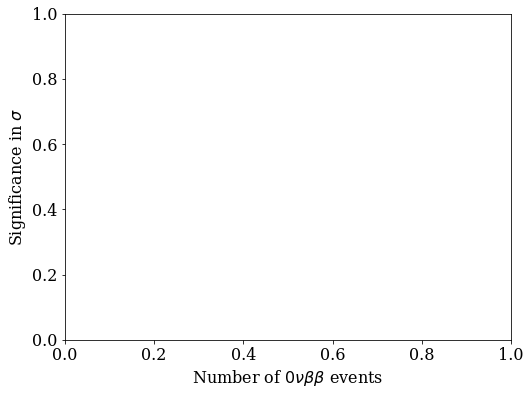

In [27]:

Halflife = {}

for ii,Mass in enumerate(XenonMass):  
    Halflife[Mass] = []
    
    plt.figure(figsize=(8,6))
    plt.xlabel(r'Number of $0\nu\beta\beta$ events')
    plt.ylabel(r'Significance in $\sigma$')
    for jj,Time in enumerate(Livetime): 
        plt.scatter(Signal[ii][jj]['Counts'], Signal[ii][jj]['Significance'], label='%d yrs' % Time, color = colors[jj], s=10, marker='x')
        
        LinearCut = np.where(np.array(Signal[ii][jj]['Significance'])<10)[0][-1]
        XInterp = np.linspace(1,Signal[ii][jj]['Counts'][LinearCut],1000)

        Interpolation = np.interp(XInterp, Signal[ii][jj]['Counts'][:LinearCut+1], Signal[ii][jj]['Significance'][:LinearCut+1])
        Diff = np.abs(Interpolation - 3.0)
        Cut = np.where(Diff == np.min(Diff))[0][0]
        
#         print(ii,jj,XInterp[Cut], Interpolation[Cut], GetHalflifeFromSignalCount(XInterp[Cut], Bb0nEfficiency, GetNumberOfXeAtoms(Mass), Time))

        plt.plot(XInterp,Interpolation, ls='--', color=colors[jj])
        
        Halflife[Mass].append(GetHalflifeFromSignalCount(XInterp[Cut], Bb0nEfficiency, GetNumberOfXeAtoms(Mass), Time))
        
    plt.xlim(0,UpperTestNumber[ii])
    plt.ylim(0,5)
    plt.title('Fiducial Mass of %d kg' % Mass, fontsize=16)
    plt.legend(loc='lower right')
    plt.savefig('significance_%dkg_%dyrs.pdf' % (Mass,Time), bbox_inches='tight')

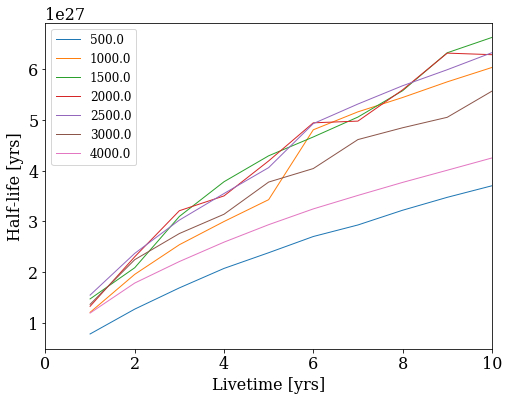

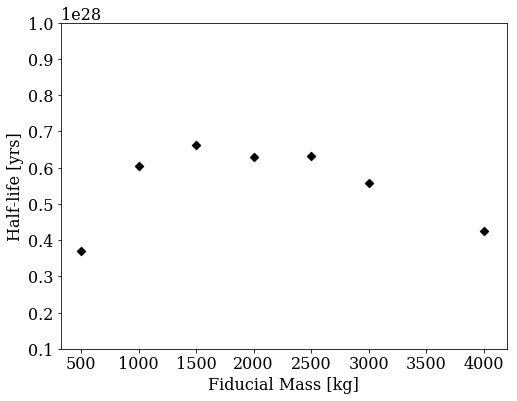

In [27]:

plt.figure(figsize=(8,6))
plt.xlabel(r'Livetime [yrs]')
plt.ylabel(r'Half-life [yrs]')
for ii,key in enumerate(Halflife.keys()):
    plt.plot(Livetime, Halflife[key], label=key)
plt.legend(loc='upper left')
plt.xlim(0,10)
plt.savefig('halflife_vs_livetime.pdf', bbox_inches='tight')

plt.figure(figsize=(8,6))
plt.xlabel(r'Fiducial Mass [kg]')
plt.ylabel(r'Half-life [yrs]')
plt.ylim(1E27, 10E27)
for ii,key in enumerate(Halflife.keys()):
    plt.scatter(float(key), Halflife[key][-1], color='k', marker='D')
plt.savefig('halflife_vs_mass.pdf', bbox_inches='tight')

In [17]:
for ii,Mass in enumerate(XenonMass): 
    print('-'*20)
    print('Running fiducial mass of %d kg' % Mass)
    
    for jj,Time in enumerate(Livetime): 
        PlotDistribution(Background[ii][jj]['BkgOnlyCounts'], Signal[ii][jj], Title='Fiducial Mass of %d kg and Livetime of %d years' % (Mass,Time), XMax=25*(ii+1))
        plt.savefig('hist_%dkg_%dyrs.pdf' % (Mass,Time), bbox_inches='tight')
        plt.close()

--------------------
Running fiducial mass of 500 kg
--------------------
Running fiducial mass of 1000 kg
--------------------
Running fiducial mass of 1500 kg
--------------------
Running fiducial mass of 2000 kg
--------------------
Running fiducial mass of 2500 kg
--------------------
Running fiducial mass of 3000 kg
--------------------
Running fiducial mass of 4000 kg


10.0


(array([  0.,   0.,   3.,   6.,  14.,  38.,  55.,  98., 122., 115., 131.,
        123.,  85.,  71.,  52.,  34.,  28.,   7.,  11.,   5.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>)

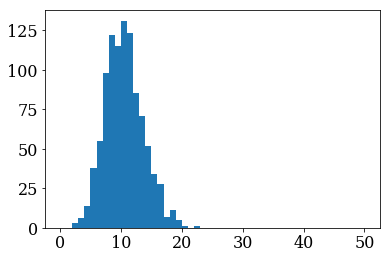

In [18]:
mu=10
test = st.poisson.rvs(mu=mu, size=1000)
print(st.poisson.median(mu=mu, loc=0))
plt.hist(test, bins=np.linspace(0,50,51))

0.1991482734714558
10.0
---
0.42319008112684364
10.0
---
0.6472318887822313
10.0
---
0.8152632445237722
10.0
---
0.9160820579686966
10.0
---


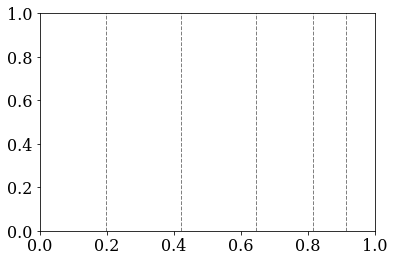

In [19]:
zvals = 1 - np.array([0.158655, 0.02275, 0.00135])
for val in [1,2,3,4,5]: 
    print(st.poisson.cdf(val, mu=3, loc=0))
    plt.axvline(x=st.poisson.cdf(val, mu=3, loc=0), ymin=0, ymax=1000, ls='--', color='grey')
    print(st.poisson.median(mu=10, loc=0))
    print('---')


In [8]:
import scipy.stats as st 
import numpy as np

In [13]:
print(st.norm.cdf(1))
print(st.norm.cdf(2))
print(st.norm.cdf(3))

0.8413447460685429
0.9772498680518208
0.9986501019683699


In [10]:
for x in np.linspace(0,100,101):
    print(x,st.poisson.cdf(k=x, mu=5))
    

0.0 0.006737946999085468
1.0 0.04042768199451279
2.0 0.12465201948308108
3.0 0.2650259152973616
4.0 0.44049328506521257
5.0 0.615960654833063
6.0 0.7621834629729387
7.0 0.8666283259299925
8.0 0.9319063652781516
9.0 0.9681719426937951
10.0 0.9863047314016171
11.0 0.9945469080869906
12.0 0.997981148372563
13.0 0.99930201002086
14.0 0.9997737463238232
15.0 0.9999309917581444
16.0 0.9999801309563696
17.0 0.99999458366173
18.0 0.9999985983021079
19.0 0.999999654786418
20.0 0.9999999189074954
21.0 0.9999999817934663
22.0 0.9999999960857323
23.0 0.9999999991927467
24.0 0.9999999998400414
25.0 0.9999999999695003
26.0 0.9999999999943963
27.0 0.9999999999990066
28.0 0.9999999999998299
29.0 0.9999999999999718
30.0 0.9999999999999954
31.0 0.9999999999999993
32.0 0.9999999999999999
33.0 1.0
34.0 1.0
35.0 1.0
36.0 1.0
37.0 1.0
38.0 1.0
39.0 1.0
40.0 1.0
41.0 1.0
42.0 1.0
43.0 1.0
44.0 1.0
45.0 1.0
46.0 1.0
47.0 1.0
48.0 1.0
49.0 1.0
50.0 1.0
51.0 1.0
52.0 1.0
53.0 1.0
54.0 1.0
55.0 1.0
56.0 1.0
57.0